TensorFlow detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training set: 31732
Validation set: 7933
Test set: 9917

TRAINING BERT MODEL


2025-11-15 09:37:05.963176: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-15 09:37:05.963235: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-15 09:37:05.963251: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-15 09:37:05.963327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-15 09:37:05.963378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized f

Froze first 8 transformer layers in BERT.
BERT Model compiled successfully.
Preparing datasets...
Starting training...
Epoch 1/10


2025-11-15 09:37:19.426089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 253s 323ms/step - loss: 0.6862 - accuracy: 0.5377 - val_loss: 0.5895 - val_accuracy: 0.7690
Epoch 2/10
750/750 [==============================] - 236s 315ms/step - loss: 0.5462 - accuracy: 0.7230 - val_loss: 0.4400 - val_accuracy: 0.8045
Epoch 3/10
750/750 [==============================] - 239s 318ms/step - loss: 0.4067 - accuracy: 0.8197 - val_loss: 0.4823 - val_accuracy: 0.7930

🧠 Gradual unfreezing: 1 top layers now trainable.
Epoch 4/10
750/750 [==============================] - 237s 317ms/step - loss: 0.3442 - accuracy: 0.8543 - val_loss: 0.5601 - val_accuracy: 0.7820
Epoch 4: early stopping
Training complete.
Evaluating BERT model...
125/125 [==============================] - 35s 257ms/step

BERT Results:
Accuracy: 0.8045
F1 Score: 0.8045

Classification Report for BERT:
              precision    recall  f1-score   support

    Negative       0.80      0.81      0.80       990
    Positive       0.81      0.80      0.81      1010

    

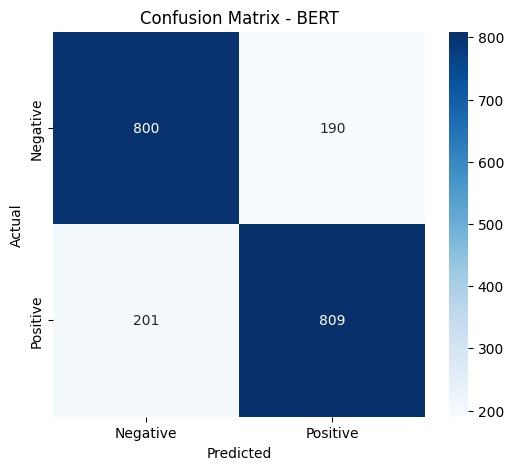


MODEL COMPARISON (3 MODELS)


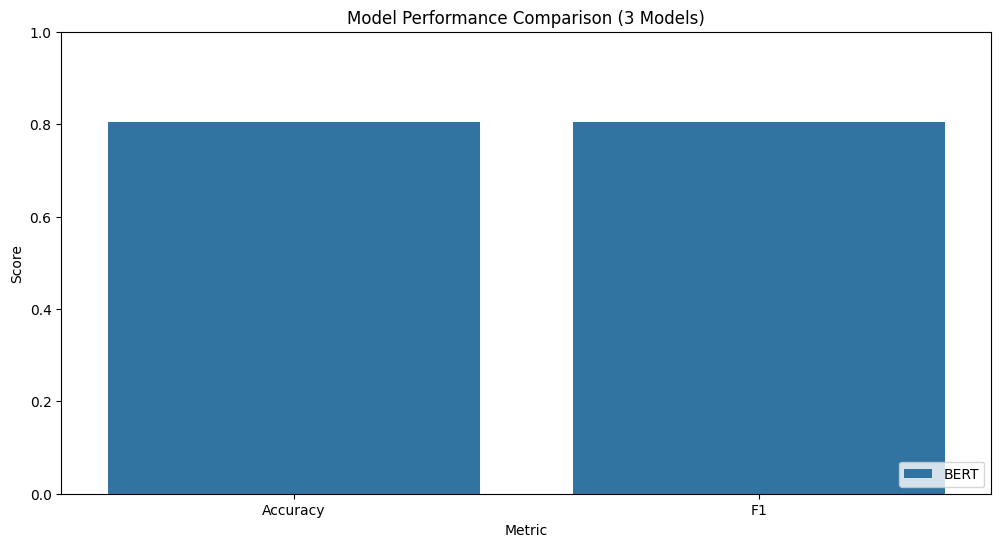


Model Comparison Summary:
Metric  Accuracy        F1
Model                     
BERT      0.8045  0.804505

FINAL REPORT

BERT:
  Accuracy: 0.8045
  F1 Score: 0.8045

🏆 Best performing model: BERT (Accuracy: 0.8045)

Analysis Complete!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import warnings
import html
import random
import os
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# TensorFlow + Hugging Face
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from transformers import (
    TFDistilBertForSequenceClassification,
    DistilBertTokenizer,
    DistilBertConfig,
    TFBertForSequenceClassification,
    BertTokenizer,
    BertConfig,
    create_optimizer
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


# BERT Model
class BertModel:
    def __init__(self, model_name='bert-base-uncased', max_length=256):
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = None
    
    def prepare_model(self, learning_rate=2e-5, weight_decay=0.01, freeze_layers=8, dropout_rate=0.3):
        config = BertConfig.from_pretrained(
            self.model_name,
            num_labels=2,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
        
        self.model = TFBertForSequenceClassification.from_pretrained(
            self.model_name, config=config
        )
        
        try:
            transformer_layers = self.model.bert.encoder.layer
            for layer in transformer_layers[:freeze_layers]:
                layer.trainable = False
            print(f"Froze first {freeze_layers} transformer layers in BERT.")
        except AttributeError:
            print("Warning: Could not access transformer layers for freezing.")
        
        optimizer, _ = create_optimizer(
            init_lr=learning_rate,
            num_train_steps=1000,
            num_warmup_steps=100,
            weight_decay_rate=weight_decay
        )
        
        self.model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        print("BERT Model compiled successfully.")
    
    def encode_texts(self, texts, labels=None, batch_size=32, shuffle=False):
        encodings = self.tokenizer(
            list(texts),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='tf'
        )
        
        if labels is not None:
            dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
        else:
            dataset = tf.data.Dataset.from_tensor_slices(dict(encodings))
        
        if shuffle:
            dataset = dataset.shuffle(2048)
        return dataset.batch(batch_size)
    
    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=16, early_stopping_patience=2):
        print("Preparing datasets...")
        train_dataset = self.encode_texts(X_train, y_train, batch_size=batch_size, shuffle=True)
        val_dataset = self.encode_texts(X_val, y_val, batch_size=batch_size)
        
        steps_per_epoch = len(X_train) // batch_size
        num_train_steps = steps_per_epoch * epochs
        num_warmup_steps = num_train_steps // 10
        
        optimizer, _ = create_optimizer(
            init_lr=2e-5,
            num_train_steps=num_train_steps,
            num_warmup_steps=num_warmup_steps,
            weight_decay_rate=0.01
        )
        
        self.model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        )
        
        gradual_unfreeze = GradualUnfreezing(self, start_epoch=3, model_type='bert')
        
        print("Starting training...")
        history = self.model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=[early_stop, gradual_unfreeze]
        )
        print("Training complete.")
        return {k: v for k, v in history.history.items()}
    
    def predict(self, texts, batch_size=16):
        dataset = self.encode_texts(texts, labels=None, batch_size=batch_size)
        preds_output = self.model.predict(dataset)
        logits = preds_output.logits if hasattr(preds_output, 'logits') else preds_output[0]
        probs = tf.nn.softmax(logits, axis=-1).numpy()
        preds = np.argmax(probs, axis=-1)
        return preds

# Gradual Unfreezing Callback

class GradualUnfreezing(tf.keras.callbacks.Callback):
    def __init__(self, model_wrapper, start_epoch=3, model_type='distilbert'):
        super().__init__()
        self.model_ref = model_wrapper
        self.start_epoch = start_epoch
        self.model_type = model_type
    
    def on_epoch_begin(self, epoch, logs=None):
        if epoch >= self.start_epoch:
            try:
                if self.model_type == 'distilbert':
                    transformer_layers = self.model_ref.model.distilbert.transformer.layer
                elif self.model_type == 'bert':
                    transformer_layers = self.model_ref.model.bert.encoder.layer
                
                layers_to_unfreeze = min(epoch - self.start_epoch + 1, len(transformer_layers))
                for layer in transformer_layers[-layers_to_unfreeze:]:
                    layer.trainable = True
                print(f"\n🧠 Gradual unfreezing: {layers_to_unfreeze} top layers now trainable.")
            except Exception as e:
                print(f"Warning: Could not unfreeze layers - {e}")


# Model Evaluator

class ModelEvaluator:
    def __init__(self):
        pass
    
    def evaluate_model(self, y_true, y_pred, model_name):
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        print(f"\n{model_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"\nClassification Report for {model_name}:")
        print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
        
        return {
            'accuracy': accuracy,
            'f1': f1,
            'classification_report': classification_report(y_true, y_pred, output_dict=True)
        }
    
    def plot_confusion_matrix(self, y_true, y_pred, model_name):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        return cm
    
    def compare_models(self, results_dict):
        models = list(results_dict.keys())
        metrics = ['accuracy', 'f1']
        
        comparison_data = []
        for model in models:
            for metric in metrics:
                comparison_data.append({
                    'Model': model,
                    'Metric': metric.capitalize(),
                    'Score': results_dict[model][metric]
                })
        
        df_comparison = pd.DataFrame(comparison_data)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df_comparison, x='Metric', y='Score', hue='Model')
        plt.title('Model Performance Comparison (3 Models)')
        plt.ylim(0, 1)
        plt.legend(loc='lower right')
        plt.show()
        
        return df_comparison


# Main Execution

use_gpu_check = True
if use_gpu_check:
    gpus = tf.config.list_physical_devices('GPU')
    print("TensorFlow detected GPUs:", gpus)

# Load preprocessed data
with open('imdb_processed.pkl', 'rb') as f:
    df_processed, label_encoder = pickle.load(f)

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_processed['processed_text'].values,
    df_processed['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df_processed['label'].values
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")

evaluator = ModelEvaluator()
results = {}

# 3. TRAIN BERT MODEL

print("\n" + "="*60)
print("TRAINING BERT MODEL")
print("="*60)

sample_size = min(3000, len(X_train))
rng = np.random.default_rng(42)
indices = rng.choice(len(X_train), sample_size, replace=False)

val_sample_size = min(2000, len(X_val))
val_indices = rng.choice(len(X_val), val_sample_size, replace=False)

bert_model = BertModel(max_length=64)
bert_model.prepare_model(
    learning_rate=2e-5,
    freeze_layers=8,  # BERT has 12 layers, freeze first 8
    dropout_rate=0.3
)

bert_history = bert_model.train(
    X_train[indices],
    y_train[indices],
    X_val[val_indices],
    y_val[val_indices],
    epochs=10,
    batch_size=4,
    early_stopping_patience=2
)

test_size = min(2000, len(X_test))

print("Evaluating BERT model...")
bert_predictions = bert_model.predict(X_test[:test_size], batch_size=16)
results['BERT'] = evaluator.evaluate_model(y_test[:test_size], bert_predictions, 'BERT')
evaluator.plot_confusion_matrix(y_test[:test_size], bert_predictions, 'BERT')



# MODEL COMPARISON

print("\n" + "="*60)
print("MODEL COMPARISON (3 MODELS)")
print("="*60)

comparison_df = evaluator.compare_models(results)
print("\nModel Comparison Summary:")
print(comparison_df.pivot(index='Model', columns='Metric', values='Score'))


# FINAL REPORT

print("\n" + "="*60)
print("FINAL REPORT")
print("="*60)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")

best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"\n🏆 Best performing model: {best_model[0]} (Accuracy: {best_model[1]['accuracy']:.4f})")
print("\nAnalysis Complete!")